In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(12)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/mai2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41975 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41517 Dashboard: http://127.0.0.1:41975/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [2]:
import numpy as np
import xarray as xr
import qgutils
import os.path as op
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
U = .1
nl = 3
T = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 1563.
# f0 = 8e-5
beta = .5
N = 256    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

In [4]:
ddir = '/store/CT1/hmg2840/tuchida/msqg-diags/seas-forcing/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/qg-ensemble/'
store = '/store/tuchida/msqg-diags/seas-forcing/ctrl/10percent/Fr-sqrt3_Ekb-2/'
# ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

In [5]:
ds = xr.open_dataset(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/vars000.nc'))
ds

<xarray.Dataset>
Dimensions:  (t: 623, x: 256, y: 256, z: 3)
Coordinates:
  * y        (y) float32 0.0 1.0 2.0 3.0 4.0 ... 251.0 252.0 253.0 254.0 255.0
  * x        (x) float32 0.0 1.0 2.0 3.0 4.0 ... 251.0 252.0 253.0 254.0 255.0
  * z        (z) float32 0.0 1.0 2.0
  * t        (t) float32 0.0 1.0 2.0 3.0 4.0 ... 618.0 619.0 620.0 621.0 622.0
Data variables:
    p        (t, z, y, x) float32 ...
    q        (t, z, y, x) float32 ...
    ptr0     (t, z, y, x) float32 ...
    ptr1     (t, z, y, x) float32 ...

In [7]:
psi = xr.DataArray(qgutils.pad_bc(ds.p.isel(t=-1)), dims=['z','y','x'],
                   coords={'z':ds.z.data,'y':range(-1,N+1),'x':range(-1,N+1)})
psi_halv = psi.interp({'y':np.arange(.5,N,2),'x':np.arange(.5,N,2)})
psi_halv

<xarray.DataArray (z: 3, y: 128, x: 128)>
array([[[ 1.69439489e-01,  3.85563537e-01,  4.57961880e-01, ...,
          1.87419620e-04,  5.63764847e-05,  5.09760753e-07],
        [ 3.94040596e-01,  8.57083365e-01,  9.63230029e-01, ...,
          8.07256110e-04,  3.23467459e-04,  5.53260081e-05],
        [ 4.80761446e-01,  9.85110536e-01,  1.02855507e+00, ...,
          1.94414519e-03,  9.06617803e-04,  2.16568369e-04],
        ...,
        [-4.40288540e-01, -8.45753074e-01, -7.28489816e-01, ...,
         -6.29451242e-03, -3.52283713e-03, -1.04909997e-03],
        [-4.14640818e-01, -8.15339401e-01, -7.37518415e-01, ...,
         -3.43534531e-03, -1.90341289e-03, -5.57918011e-04],
        [-1.75777569e-01, -3.42912361e-01, -3.07493150e-01, ...,
         -1.06649318e-03, -5.84747402e-04, -1.68554176e-04]],

       [[-1.00876827e-02, -1.66646204e-02, -3.67971836e-02, ...,
          5.26129024e-05, -2.10781457e-05, -2.36204430e-05],
        [-9.40320110e-02, -1.71613447e-01, -2.04395939e-01, ...,
          1.59515328e-04, -6.23592641e-05, -7.05299144e-05],
        [-1.84842197e-01, -3.78791422e-01, -4.28837031e-01, ...,
          2.60366050e-04, -1.07366975e-04, -1.18444901e-04],
...
        [ 3.53201136e-01,  6.24552950e-01,  5.76731563e-01, ...,
         -4.58683685e-03, -2.48528249e-03, -7.03740719e-04],
        [ 2.85616752e-01,  5.01224920e-01,  4.05649163e-01, ...,
         -2.77243124e-03, -1.50309684e-03, -4.25781356e-04],
        [ 9.60765909e-02,  1.60927013e-01,  1.21663455e-01, ...,
         -9.26433946e-04, -5.02391049e-04, -1.42318710e-04]],

       [[-2.85152788e-02, -5.16879940e-02, -4.67293989e-02, ...,
          5.16018081e-05, -1.94649713e-05, -2.22585493e-05],
        [-7.54864085e-02, -1.35089213e-01, -1.19066469e-01, ...,
          1.50609410e-04, -5.99140872e-05, -6.69689025e-05],
        [-9.63210193e-02, -1.66870095e-01, -1.35898922e-01, ...,
          2.37129454e-04, -1.04884866e-04, -1.12256799e-04],
        ...,
        [ 9.78580760e-02,  1.49594702e-01,  7.31959827e-02, ...,
         -4.51903214e-03, -2.44520689e-03, -6.89713655e-04],
        [ 1.10261792e-01,  1.93058431e-01,  1.36000177e-01, ...,
         -2.73659331e-03, -1.47980076e-03, -4.17118783e-04],
        [ 5.74193345e-02,  1.03901219e-01,  7.65339341e-02, ...,
         -9.16413643e-04, -4.95389344e-04, -1.39590080e-04]]])
Coordinates:
  * z        (z) float32 0.0 1.0 2.0
  * y        (y) float64 0.5 2.5 4.5 6.5 8.5 ... 246.5 248.5 250.5 252.5 254.5
  * x        (x) float64 0.5 2.5 4.5 6.5 8.5 ... 246.5 248.5 250.5 252.5 254.5

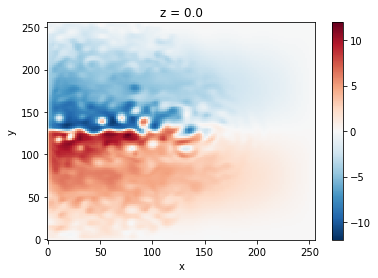

In [8]:
psi_halv.isel(z=0).plot()

In [9]:
Nz, Ny, Nx = psi_halv.shape
p_bas = np.zeros((Nz,Ny+1,Nx+1))
p_bas[:,1:,1:] = psi_halv.data
p_bas[:,0,0] = Ny
p_bas = np.transpose(p_bas, (0,2,1))
# p_bas.astype('f4').tofile(work+'p0-seas%02dpercent_nonperturb_%03d.bas' % (percent,ver))
# p_bas.astype('f4').tofile(work+'p0-seas20percent_nonperturb_%03d.bas' % (ver))
# p_bas.astype('f4').tofile(work+'runs/const-forcing/with-ptrs/control/Fr_sqrt3_Ekb_2/p0_%03d.bas' % (ver))
p_bas.astype('f4').tofile(scratch+'initial-cond/p0_N128-from-N256.bas')

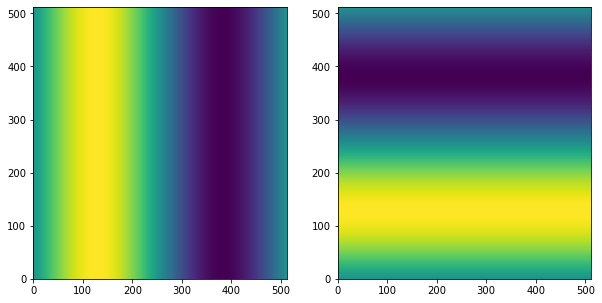

In [8]:
# Delta = 1/N
x = np.linspace(-1.,1.,N*2)
sin = np.sin(2*np.pi*np.linspace(0,1,N*2))

ptr0 = np.zeros((nl,N*2,N*2))
ptr0 += x[np.newaxis,np.newaxis,:]

ptr1 = np.zeros((nl,N*2,N*2))
ptr1 += x[np.newaxis,:,np.newaxis]

ptr2 = np.zeros((nl,N*2,N*2))
ptr2 += sin[np.newaxis,np.newaxis,:]

ptr3 = np.zeros((nl,N*2,N*2))
ptr3 += sin[np.newaxis,:,np.newaxis]

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.pcolormesh(ptr2[0])
ax2.pcolormesh(ptr3[0])

In [9]:
nptr = 4
ptr = np.zeros((nl*nptr,N*2+1,N*2+1))
ptr[:,0,0] = N*2
ptr[0::nptr,1:,1:] = ptr0
ptr[1::nptr,1:,1:] = ptr1
ptr[2::nptr,1:,1:] = ptr2
ptr[3::nptr,1:,1:] = ptr3
ptr = np.transpose(ptr,(0,2,1))
ptr.astype('f4').tofile(scratch+'initial-cond/ptr_init.bas')
ptr.astype('f4').tofile(scratch+'initial-cond/ptr_relx.bas')

# Generate perturbed initial condition

In [ ]:
ds = xr.open_dataset(op.join(store,'N512/vars.nc'))

In [ ]:
Ns,Ne = (0,100)
for i in range(Ns,Ne):
    j = np.random.randint(0,int(len(ds.x)*len(ds.y)))
    print(j)
    k = 1e-31 * np.random.standard_normal()
    p = ds.p.isel(t=-1,z=0).load().data.ravel()
    p[j] += k
    psave = xr.concat([xr.DataArray(p.reshape((1,len(ds.y),len(ds.x))), dims=['z','y','x'], 
                                    coords={'z':np.array([0.]), 'y':ds.y.data, 'x':ds.x.data}, name='p'),
                       ds.p.isel(t=-1,z=slice(1,None)).drop('t')], 
                      'z')
    if i % 10 == 0:
        print(psave)
        fig, ax = plt.subplots()
        psave.isel(z=0).plot(ax=ax, vmax=15)
        plt.show()
    
    Nz, Ny, Nx = psave.shape
    p_bas = np.zeros((Nz,Ny+1,Nx+1))
    p_bas[:,1:,1:] = psave.data
    p_bas[:,0,0] = Ny
    p_bas = np.transpose(p_bas, (0,2,1))
    p_bas.astype('f4').tofile(scratch+'initial-cond/psi-perturbed/p0-seas_%02dpercent_%03d.bas' % (percent,i))